In [106]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#1-Import + Carga de datos

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
data=pd.read_csv('/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/AMAZON_FASHION.csv')
data=data[:100000]

In [92]:
data

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3.0,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5.0,True,"10 21, 2016",A37MJS0K04JHN3,B009UAMWR0,Nancy Lavoie,This is such a beautiful necklace. I wear it ...,Love this necklace.,1477008000,NaN,"{'Length:': ' 18.00', 'Metal Type:': ' rose-go...",NaN
99996,5.0,True,"10 1, 2016",AJVP9DKB0YHWQ,B009UAMWR0,Angela F.,Good sized necklace - good for those who prefe...,Very pretty - substantial size,1475280000,NaN,"{'Length:': ' 20.00', 'Metal Type:': ' sterlin...",NaN
99997,5.0,True,"09 28, 2016",A303I4DSB1SAD9,B009UAMWR0,jamila franklin,Way above my expectations. I wear it everyday ...,Above and beyond expectations!,1475020800,NaN,"{'Length:': ' 18.00', 'Metal Type:': ' sterlin...",NaN
99998,4.0,True,"09 26, 2016",A3MUAJIDZ9BR2R,B009UAMWR0,Morrcellia,Overall happy with the finished product. My c...,Not bad...,1474848000,NaN,"{'Length:': ' 20.00', 'Metal Type:': ' sterlin...",['https://images-na.ssl-images-amazon.com/imag...


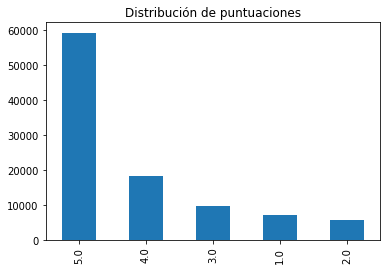

In [93]:
data['overall'].value_counts().plot(kind='bar', title='Distribución de puntuaciones')

#2-Preprocesamiento de datos

In [108]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop rows with missing reviews
    missing_review_rows = df[df['reviewText'].isna()].index
    df = df.drop(missing_review_rows, axis=0).reset_index(drop=True)
    
    
    # Use only the review and rating column
    y = df['overall']
    X = df['reviewText']

    #Pasamos a one-hot encoding
    y = y.astype(int)
    onehotencoder = OneHotEncoder()
    y = onehotencoder.fit_transform(y.values.reshape(-1,1)).toarray()

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)


    # Learn the vocabulary
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)
    
    
    # Find the size of the vocabulary
    vocab_length = len(tokenizer.word_index) + 1
    print("Vocab length:", vocab_length)
    
    
    # Convert review texts into sequences of integers
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    
    # Find the maximum sequence length
    max_seq_length = np.max(list(map(lambda x: len(x), X_train)))
    print("Maximum sequence length:", max_seq_length)

    
    # Pad the sequences to by uniform length
    X_train = pad_sequences(X_train, maxlen=max_seq_length, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_seq_length, padding='post')
    
    
    return X_train, X_test, y_train, y_test, vocab_length, max_seq_length

In [109]:
X_train, X_test, y_train, y_test, VOCAB_LENGTH, MAX_SEQ_LENGTH = preprocess_inputs(data)

Vocab length: 27211
Maximum sequence length: 1293


In [49]:
X_train, X_train.shape

(array([[   5,    9,   57, ...,    0,    0,    0],
        [  10,    9,    1, ...,    0,    0,    0],
        [   2, 1659,    1, ...,    0,    0,    0],
        ...,
        [1614,    4, 5866, ...,    0,    0,    0],
        [ 208,    0,    0, ...,    0,    0,    0],
        [  33,    5,    0, ...,    0,    0,    0]], dtype=int32),
 (79912, 1293))

In [18]:
X_test.shape

(19979, 1293)

In [22]:
y_train[:5], y_test[5:]

(array([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.]]), array([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]))

#3-Entrenamiento

**3.1.1-Creacion del modelo lstm**

In [110]:
def crear_modelo_lstm(X_train):
    inputs = tf.keras.Input(shape=(X_train.shape[1],))

    word_embedding = tf.keras.layers.Embedding(
        input_dim=VOCAB_LENGTH,
        output_dim=32,
        input_length=MAX_SEQ_LENGTH
    )(inputs)

    word_flatten = tf.keras.layers.Flatten()(word_embedding)
    gru = tf.keras.layers.LSTM(64, return_sequences=False, activation='tanh', dropout=0.15)(word_embedding)

    concat = tf.keras.layers.concatenate([word_flatten, gru])

    outputs = tf.keras.layers.Dense(5, activation='sigmoid')(concat)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    print(model.summary())
    return model

**3.1.2-Creacion del modelo gru**

In [111]:
def crear_modelo_gru(X_train):
    inputs = tf.keras.Input(shape=(X_train.shape[1],))

    word_embedding = tf.keras.layers.Embedding(
        input_dim=VOCAB_LENGTH,
        output_dim=32,
        input_length=MAX_SEQ_LENGTH
    )(inputs)

    word_flatten = tf.keras.layers.Flatten()(word_embedding)
    gru = tf.keras.layers.GRU(64, return_sequences=False, activation='tanh')(word_embedding)

    concat = tf.keras.layers.concatenate([word_flatten, gru])

    outputs = tf.keras.layers.Dense(5, activation='sigmoid')(concat)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    print(model.summary())
    return model

**3.2-Entrenamiento del modelo**

**LSTM**

In [60]:
modelo_lstm = crear_modelo_lstm(X_train)
modelo_lstm.compile(
    optimizer='adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)



path_checkpoint = "/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_lstm/weights_multiclass_lstm.h5"


early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)



history = modelo_lstm.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,

    steps_per_epoch=350,
    validation_steps=500,

    callbacks=[early_stopping, modelckpt_callback]
)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1293)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1293, 32)     870752      input_11[0][0]                   
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 41376)        0           embedding_10[0][0]               
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           24832       embedding_10[0][0]               
___________________________________________________________________________________________

**GRU**

In [74]:
modelo_gru = crear_modelo_gru(X_train)
modelo_gru.compile(
    optimizer='adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)



path_checkpoint = "/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_gru/weights_multiclass_gru.h5"


early_stopping = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)



history = modelo_gru.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,

    steps_per_epoch=350,
    validation_steps=500,

    callbacks=[early_stopping, modelckpt_callback]
)

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 1293)]       0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1293, 32)     870752      input_18[0][0]                   
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 41376)        0           embedding_17[0][0]               
__________________________________________________________________________________________________
gru_14 (GRU)                    (None, 64)           18816       embedding_17[0][0]               
___________________________________________________________________________________________

**3.3-Guardamos los pesos y el historico de entrenamiento**

In [61]:
modelo_lstm.save("/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_lstm/modelo_multiclass_lstm.h5")
import pickle
with open('/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_lstm/history_multiclass_lstm', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [75]:
modelo_gru.save("/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_gru/modelo_multiclass_gru.h5")
import pickle
with open('/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_gru/history_multiclass_gru', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

#4-Evaluacion de modelos

**4.1-Cargamos los modelos ya entrenados**

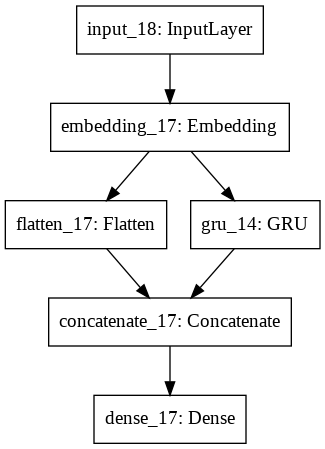

In [114]:
model_gru = tf.keras.models.load_model("/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_gru/modelo_multiclass_gru.h5")
history_gru = pickle.load(open('/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_gru/history_multiclass_gru', "rb"))
tf.keras.utils.plot_model(model_gru)

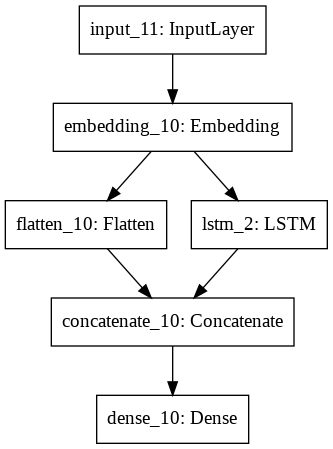

In [113]:
model_lstm = tf.keras.models.load_model("/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_lstm/modelo_multiclass_lstm.h5")
history_lstm = pickle.load(open('/content/drive/MyDrive/Web-Science/Predict_amazon_score_from_review/modelo_lstm/history_multiclass_lstm', "rb"))
tf.keras.utils.plot_model(model_lstm)

**4.2-Evaluamos la precisión general de los modelos**

In [77]:
model_gru.evaluate(X_test, y_test)

625/625 [==============================] - 50s 80ms/step - loss: 0.7453 - accuracy: 0.7225


[0.7452969551086426, 0.7224586009979248]

In [72]:
model_lstm.evaluate(X_test, y_test)

625/625 [==============================] - 50s 79ms/step - loss: 0.7426 - accuracy: 0.7267


[0.7426211833953857, 0.7267130613327026]

**4.3-Evaluacion fase de entrenamiento**

In [78]:
def plot_train_history_cargados(history, title):
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

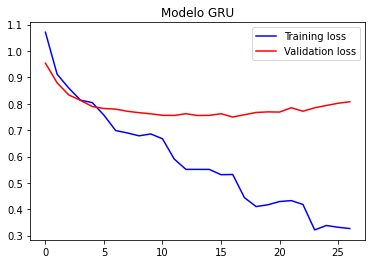

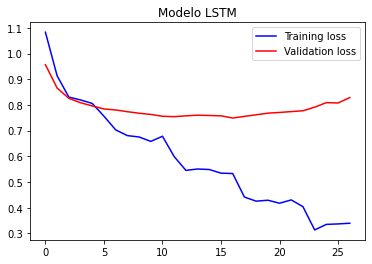

In [79]:
import matplotlib.pyplot as plt
plot_train_history_cargados(history_gru, 'Modelo GRU'),
plot_train_history_cargados(history_lstm, 'Modelo LSTM')

**4.4-Evaluacion de predicciones**

**4.4.1**-Realizamos predicciones con ambos modelos para el conjunto de prueba

In [115]:
predicciones_gru  = model_gru.predict(X_test)
predicciones_lstm = model_lstm.predict(X_test)

In [116]:
predicciones_gru

array([[9.6331912e-01, 9.0048468e-01, 3.5458761e-01, 2.2968942e-02,
        7.5064683e-01],
       [8.8681465e-01, 6.9384450e-01, 5.6963271e-01, 3.0323619e-01,
        3.8790789e-01],
       [5.1497307e-04, 1.0952018e-02, 5.0585806e-01, 7.8877091e-01,
        9.9439174e-01],
       ...,
       [1.6773604e-02, 1.6989060e-02, 1.5485923e-01, 8.0647147e-01,
        9.7697711e-01],
       [9.4585285e-02, 1.8557586e-01, 6.5414184e-01, 4.3019375e-01,
        8.9497072e-01],
       [7.3198825e-02, 5.5023111e-02, 2.9999664e-01, 7.5567091e-01,
        9.1196579e-01]], dtype=float32)

**4.4.2**-Ponemos el numero de clase al que corresponde el que mayor probabilidad tiene y dejamos a 0 el resto

In [124]:
predicciones_gru_finales = np.argmax(predicciones_gru, 1)
predicciones_gru_finales

array([0, 0, 4, ..., 4, 4, 4])

In [126]:
predicciones_lstm_finales = np.argmax(predicciones_lstm, 1) 
predicciones_lstm_finales

array([1, 0, 4, ..., 4, 4, 4])

In [127]:
y_test_comp = np.argmax(y_test, 1)
y_test_comp

array([1, 0, 3, ..., 4, 4, 4])

**4.4.3**-Creamos la matriz de correlación para ver la precisión de cada una de las clases predichas.

In [175]:
matriz_gru = confusion_matrix(y_test_comp ,predicciones_gru_finales)


matriz_lstm = confusion_matrix(y_test_comp ,predicciones_lstm_finales)
matriz_lstm.diagonal()/matriz_lstm.sum(axis=1), matriz_gru.diagonal()/matriz_gru.sum(axis=1)

matriz_lstm_resultante = np.round(matriz_lstm.diagonal()/matriz_lstm.sum(axis=1), 3)

matriz_gru_resultante  = np.round(matriz_gru.diagonal()/matriz_gru.sum(axis=1), 3)

In [188]:
matriz_lstm_resultante, matriz_gru_resultante

(array([0.684, 0.267, 0.407, 0.384, 0.932]),
 array([0.692, 0.214, 0.447, 0.404, 0.916]))

**4.4.4**-Mostramos una comparativa gráfica entre los dos modelos con la precisión obtenida para cada una de las clases

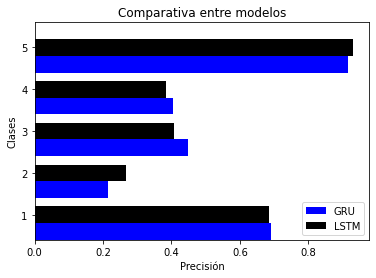

In [194]:

df = pd.DataFrame(dict(graph=['1', '2', '3', '4', '5'],
                           n=matriz_gru_resultante, m=matriz_lstm_resultante)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.n, width, color='blue', label='GRU')
ax.barh(ind + width, df.m, width, color='black', label='LSTM')

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()


plt.title('Comparativa entre modelos')
plt.ylabel('Clases')
plt.xlabel('Precisión')

plt.show()